Titanic: Machine Learning from Disaster
========================

In [1]:
import numpy as np
print('numpy: %s' % np.__version__)
import pandas as pd
print('pandas: %s' % pd.__version__)
import matplotlib as mpl
print('matplotlib: %s' % mpl.__version__)
import seaborn as sns
print('seaborn: %s' % sns.__version__)
import sklearn as skl
print('scikit-learn: %s' % skl.__version__)

pd.options.mode.chained_assignment = None
%matplotlib inline

numpy: 1.14.3
pandas: 0.22.0+0.ga00154d.dirty
matplotlib: 2.2.2
seaborn: 0.8.1
scikit-learn: 0.19.1


# 1. Exploratory Data Analysis

* Pclass = Ticket class (1st, 2nd, 3rd) 
* SibSp  = number of siblings/spouse aboard the Titanic
* Parch  = number of parents/children aboard the Titanic
* Embarked = port of embarkation (C=Cherbourg, S=Southampton, Q=Queenstown) 

Titanic took of from Southampton (England), through Cherbourg (France) and finally Queenstown (Ireland).

In [145]:
data = pd.read_csv('./data/Titanic/train.csv')
print( data.head(1) )

   PassengerId  Survived  Pclass                     Name   Sex   Age  SibSp  \
0            1         0       3  Braund, Mr. Owen Harris  male  22.0      1   

   Parch     Ticket  Fare Cabin Embarked  
0      0  A/5 21171  7.25   NaN        S  


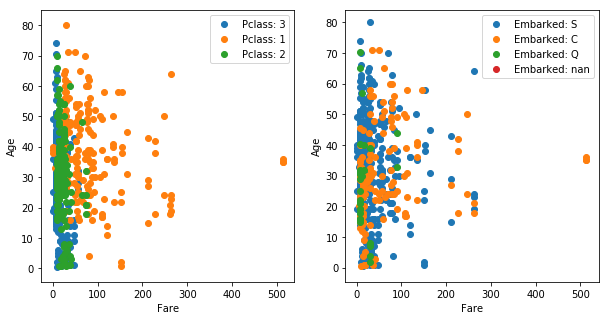

In [146]:
plt.close()

fig, ax = plt.subplots(figsize=(10,5),
                       nrows=1,
                       ncols=2
                      )

for pclass in data['Pclass'].unique():
    plot_data = data[data['Pclass'] == pclass][['Fare','Age']]
    ax[0].scatter(plot_data['Fare'],
                  plot_data['Age'],
                  marker='o',
                  label='Pclass: %d' % pclass
                 )
ax[0].set_xlabel('Fare')
ax[0].set_ylabel('Age')
ax[0].legend()

for name in data['Embarked'].unique():
    plot_data = data[data['Embarked'] == name][['Fare','Age']]
    ax[1].scatter(plot_data['Fare'],
                  plot_data['Age'],
                  marker='o',
                  label='Embarked: %s' % name
                 )
ax[1].set_xlabel('Fare')
ax[1].set_ylabel('Age')
ax[1].legend()

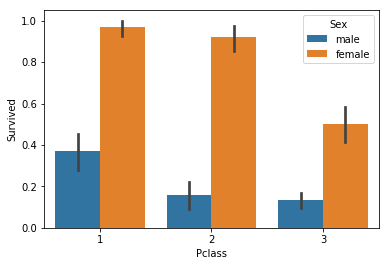

In [147]:
sns.barplot( x="Pclass", y="Survived", hue="Sex", data=data)

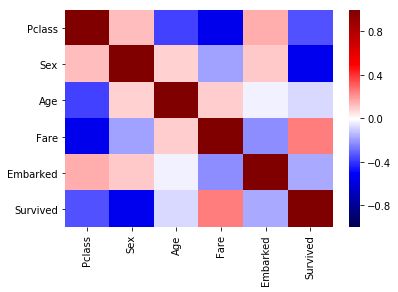

In [148]:
pd.options.mode.chained_assignment = None

X = data[['Pclass','Sex','Age','Fare','Embarked','Survived']]

from sklearn.preprocessing import LabelEncoder

label_encoder_sex = LabelEncoder()
X['Sex'] = label_encoder_sex.fit_transform(X['Sex'])

# find most frequent value
mode = X['Embarked'].mode().iloc[0]
X['Embarked'].fillna(mode, inplace=True)
label_encoder_embarked = LabelEncoder()
X['Embarked'] = label_encoder_embarked.fit_transform(X['Embarked'])

sns.heatmap(X.corr(),
            vmin=-1.0,
            vmax=1.0,
            cmap='seismic'
           )

## 1.1 Passenger class (Pclass)
We would like to check waht is the empirical probability of surviving the disaster given that the person belongs to one of the 3 different classes:
$$P(y=1|\text{Pclass}=c,\mathcal{D}) = ?$$

In [94]:
data[['Pclass','Survived']].groupby('Pclass').aggregate(['mean','count'])

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

# 1.2 Passenger Sex
What is the probability of survival given the person's gender:
$$P(y=1|\text{Sex}=c, \mathcal{D}) = ?$$

In [93]:
data[['Sex','Survived']].groupby('Sex').aggregate(['mean','count'])

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

# 1.3 Embarked
What is the probability of survival given that the person checked in one of the three cities:
$$P(y=1|\text{Embarked}=c,\mathcal{D}) = ?$$

In [92]:
data[['Embarked','Survived']].groupby('Embarked').aggregate(['mean','count'])

Survived      
              mean count
Embarked                
C         0.553571   168
Q         0.389610    77
S         0.339009   646

# 1.4 Number of siblings/spouse (SibSp)

In [91]:
data[['SibSp','Survived']].groupby('SibSp').aggregate(['mean','count'])

Survived      
           mean count
SibSp                
0      0.345395   608
1      0.535885   209
2      0.464286    28
3      0.250000    16
4      0.166667    18
5      0.000000     5
8      0.000000     7

# 1.5 Number of parents/children

In [90]:
data[['Parch','Survived']].groupby('Parch').aggregate(['mean','count'])

Survived      
           mean count
Parch                
0      0.343658   678
1      0.550847   118
2      0.500000    80
3      0.600000     5
4      0.000000     4
5      0.200000     5
6      0.000000     1

XGBoost Classifier
==
Firstly, we wil try to predict survival chances based on the following features:
* Pclass
* Sex
* Age
* Fare
* Embarked
* ....
---
1. In the first try, we will use `LabelEncoder` to change categorical variables into numerical values.
2. In the second try, we will use `OneHotEncoder` to encode categorical variables.
---
### Feature engineering & transformation
1. Integer encoding of categorical variables.
2. OneHotEncoding of categorical variables.
3. Categorization of continuous variables (e.g. Age, Fare).
4. Creating new features (e.g. FamilySize, IsAlone, Title). 
5. Imputing missing values.
---
**Early stopping** approach to avoid overfitting.

[machinelearningmastery](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

In [ ]:
data_train = pd.read_csv('./data/Titanic/train.csv')

# print Nan statistic
print('---------------------------')
print('Train data')
print('---------------------------')
print('data length: %d' % len(data_train))
print('---------------------------')
print(data_train.isna().sum().transpose())

In [149]:
def feature_transform(data, extra=None, use_dummy=False):
    '''Generate feature X and predictor y variables based on the data set.

    Parameters
    ==========
    
    data: pd.DataFrame
        input data set
        
    extra: list
        extra columns to include
        
    use_dummy: Boolean
        specify if you want to use dummy variables
        for categorical features
        
    Return
    ======
    
    (X,y): tuple (pd.DataFrame, pd.Series)
    '''
    
    import re
    from sklearn.preprocessing import LabelEncoder
    
    # base variable
    try:
        y = data['Survived']
    except:
        y=None
        
    X = data[['Pclass','Sex','Age','Fare','Embarked']]
    
    if extra:
        for name in extra:
            
            # -----------------
            # Title imputation
            # -----------------
            if name == 'Title':
                title = data['Name'].apply(lambda row:
                                           re.search(' ([A-Za-z]+)\.', row).group(1) 
                                          )
                title.replace(['Don','Rev','Dr',
                               'Major','Col','Capt',
                               'Countess','Jonkheer'], 'Other', inplace=True)
                title.replace(['Sir'], 'Mr', inplace=True)
                title.replace(['Mlle','Lady','Ms'], 'Miss', inplace=True)
                title.replace(['Mme'], 'Mrs', inplace=True)
            
                X['Title'] = title.astype(np.object)
                
            elif name == 'FamilySize':
                X['FamilySize'] = data['SibSp'] + data['Parch'] + 1
                
            elif name == 'IsAlone':
                family_size = data['SibSp'] + data['Parch'] + 1
                X['IsAlone'] = 0
                X.loc[family_size == 1, 'IsAlone'] = 1
            
            else:
                X[name] = data[name]
    
    # Encode features
    category = X.dtypes[X.dtypes == np.object].index.tolist()

    if use_dummy:
        for col_name in category:
            df = pd.get_dummies(X[col_name])
            X.drop(col_name, axis=1, inplace=True)
            X = X.join(df)
            
    else:
        lb = LabelEncoder()
        
        for col_name in category:
            X[col_name] = lb.fit_transform(X[col_name].astype(str))
        
    return(X,y)
                
def xgboost_score(X, y, n_trees=30):
    '''Use XGBoost Classifier for predicitions and output accuracy score
    
    Parameter
    =========
    
    X: pd.DataFrame
        feature variable
        
    y: pd.Series
        predictor variable
        
    n_trees: Integer (default=30)
        limit on the number of trees in XGBoost
        
    Return
    ======
    
    accuracy: float
    '''
    
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    from xgboost import XGBClassifier

    estimator = XGBClassifier()
    
    from sklearn.cross_validation import train_test_split 

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=143
                                                       )
    estimator.fit(X_train, y_train)
    
    y_pred = estimator.predict(X_test, ntree_limit=n_trees)

    from sklearn.metrics import accuracy_score

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy * 100.0

In [150]:
X, y = feature_transform(data_train, extra=['FamilySize','Title'], use_dummy=False)
xgboost_score(X, y, n_trees=25)

81.00558659217877

# Tuning XGBoost

In [117]:
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=143)

In [118]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from xgboost import XGBClassifier

estimator = XGBClassifier()
print(estimator.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


In [119]:
# Optimal tree size
estimator.fit(X_train, y_train, 
              eval_metric=['error','logloss'], 
              eval_set=[(X_train, y_train),(X_test, y_test)],
              early_stopping_rounds=None,
              verbose=False
             )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

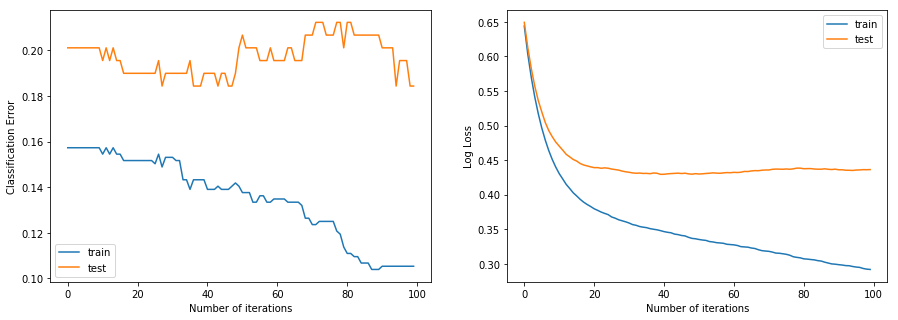

In [120]:
results = estimator.evals_result()

import matplotlib.pyplot as plt
plt.close()

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2, gridspec_kw={'wspace':0.2})

ax[0].plot(results['validation_0']['error'], label='train')
ax[0].plot(results['validation_1']['error'], label='test')
ax[0].set_xlabel('Number of iterations')
ax[0].set_ylabel('Classification Error')
ax[0].legend()

ax[1].plot(results['validation_0']['logloss'], label='train')
ax[1].plot(results['validation_1']['logloss'], label='test')
ax[1].set_xlabel('Number of iterations')
ax[1].set_ylabel('Log Loss')
ax[1].legend()

In [121]:
from sklearn.model_selection import GridSearchCV

param_grid = {'reg_alpha':np.linspace(0.,10.,5), 'reg_lambda':np.linspace(0.,10.,5), 'n_estimators':[15,20,40,60], 'seed':[1337]}

clf = GridSearchCV(estimator,
                   param_grid=param_grid,
                   scoring='accuracy',
                   cv=10
                  )
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_alpha': array([ 0. ,  2.5,  5. ,  7.5, 10. ]), 'reg_lambda': array([ 0. ,  2.5,  5. ,  7.5, 10. ]), 'n_estimators': [15, 20, 40, 60], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [122]:
print("Best score: %.2f%%" % (clf.best_score_*100))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 83.85%
Best parameter set: {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 2.5, 'seed': 1337}


In [134]:
from sklearn.metrics import accuracy_score

y_pred = clf.best_estimator_.predict(X_test, ntree_limit=18)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.01%


0.8477011494252873


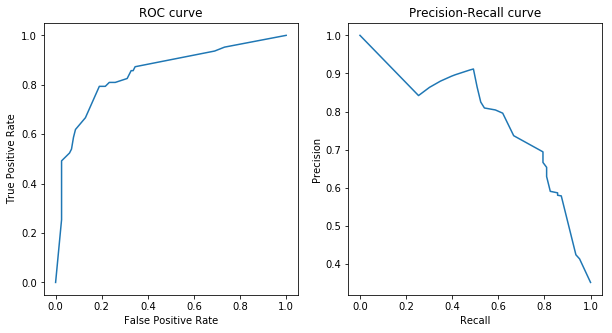

In [143]:
# ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, clf.best_estimator_.predict_proba(X_test, ntree_limit=18)[:,1])
precision, recall, threshold = \
    precision_recall_curve(y_test, clf.best_estimator_.predict_proba(X_test, ntree_limit=18)[:,1])

plt.close()

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

ax[0].plot(fpr,tpr)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve')

ax[1].plot(recall,precision)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

print(roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test, ntree_limit=18)[:,1]))

In [196]:
# train on a full data
estimator = XGBClassifier(n_estimators=20, reg_alpha=0.0, reg_lambda=2.5, seed=1337)
estimator.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.0, reg_lambda=2.5, scale_pos_weight=1, seed=1337,
       silent=True, subsample=1)

In [168]:
from sklearn.metrics import accuracy_score

y_pred = estimator.predict(X, ntree_limit=20)

accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.18%


In [197]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator,X,y,cv=20)

array([0.76086957, 0.89130435, 0.77777778, 0.91111111, 0.75555556,
       0.77777778, 0.82222222, 0.86666667, 0.86666667, 0.86363636,
       0.81818182, 0.79545455, 0.77272727, 0.84090909, 0.79545455,
       0.75      , 0.84090909, 0.90909091, 0.81818182, 0.86363636])

In [198]:
data_test = pd.read_csv('./data/Titanic/test.csv')

X_test, y_test = feature_transform(data_test, extra=['FamilySize','Title'], use_dummy=False)

Y_pred = estimator.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./data/Titanic/submission.csv', index=False)